Preprocessing...
Obtaining Depth Estimate Data...
Obtaining True Depth Data...
Obtaining Segmented Data...
(1449, 480, 640)
(1449, 480, 640)
(1449, 480, 640)
Forming Network...
(1304, 240, 320, 1)
(145, 240, 320, 1)
(1304, 240, 320, 1)
(145, 240, 320, 1)
(1304, 240, 320, 1)
(145, 240, 320, 1)


/Users/williamherbosch/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:176: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 240, 320, 1)  0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 240, 320, 2)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 320, 64) 1216        concatenate_1[0][0]              
__________

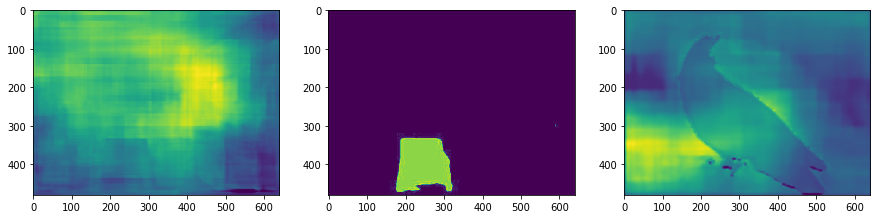

In [31]:
#William Herbosch - UCL Research Project 2018-19 - Virtual Annotator System
#Regressively Measuring Distance through depth maps and segmented images on a single image.
#
#This code is wholy the work of the student. 

#For Google Colabratory, please ensure the connection to the local runtime. 
#Note: This will assume the program to run in the local directory.

## Imports
from PIL import Image  #Python Image Library Operator
import glob
import cv2
import random
import sys
import scipy.io #For reading in the depth images
import scipy.misc
import numpy as np  #Numerical computations
from matplotlib import gridspec  #Needed for plotting the colourmap
from matplotlib import pyplot as plt  #Needed for plotting the images
from sklearn.model_selection import train_test_split as tts  #Splits data

#Neural Network
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as keras
keras.clear_session()

#Needed for reading files in test directory
from os import listdir, mkdir
from os.path import isfile, join
import os

##############################################################################################################################
## SETTINGS. PLEASE READ:  

#Specify the name of the test image (assume root is tensorflow/model/research/deeplab/*)
To_Be_Tested_Dep = "tensorflow/models/research/deeplab/Dep_out.mat"
To_Be_Tested_Seg = "tensorflow/models/research/deeplab/g3doc/img/SegmentedImages/Bird.jpg"

#Learning in groups of
batch_size = 4

#Learning iterations 
epochs = 1

#Train the model (True) or load in a model (False):
Train = False

##############################################################################################################################
## Globals
#Directories for train and test (assume root is tensorflow/model/research/deeplab/*):
Name_of_DepthImages_directory = "tensorflow/models/research/deeplab/NYU_Dep_Outs"
Name_of_TrueDepthImages_directory = "tensorflow/models/research/deeplab/g3doc/img/TestImages/NYU_Depths"
Name_of_SegmentedImages_directory = "tensorflow/models/research/deeplab/g3doc/img/SegmentedImages/NYU_Images"

#List storage for the images/depths
DepthImage_list = []
TrueDepthImage_list = []
SegmentedImage_list = []

#Resize
resize_H = 240
resize_W = 320

## Methods
#Preprocess and obtain images/depths/segments
def preprocess():    
    #Depth images
    print("Obtaining Depth Estimate Data...")
    #Obtain all file names within the test image directory
    DEPimgs = [f for f in listdir(Name_of_DepthImages_directory) if isfile(join(Name_of_DepthImages_directory, f))]
    DEPimgs.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #For each depth image, convert from mat to np.array and store in list
    for i in DEPimgs: 
        #Importing .mat data (i.e. the depth maps) into python as arrays    
        mat = scipy.io.loadmat(Name_of_DepthImages_directory + '/' + i)
        list_values = [v for v in mat.values()]
        this_depth_map = list_values[3]
        DepthImage_list.append(this_depth_map)
    print("Obtaining True Depth Data...")
    #Obtain all file names within the test image directory
    TDEPimgs = [f for f in listdir(Name_of_TrueDepthImages_directory) if isfile(join(Name_of_TrueDepthImages_directory, f))]
    TDEPimgs.remove('.DS_Store')
    TDEPimgs.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #For each depth image, convert from mat to np.array and store in list
    for i in TDEPimgs: 
        #Importing .mat data (i.e. the depth maps) into python as arrays    
        mat = scipy.io.loadmat(Name_of_TrueDepthImages_directory + '/' + i)
        list_values = [v for v in mat.values()]
        this_depth_map = list_values[3]
        TrueDepthImage_list.append(this_depth_map)    
    #Segment images
    print("Obtaining Segmented Data...")
    SEGimgs = [f for f in listdir(Name_of_SegmentedImages_directory) if isfile(join(Name_of_SegmentedImages_directory, f))]
    SEGimgs.remove('.DS_Store')
    SEGimgs.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #for each image, open and convert to np.array and store in list
    for i in SEGimgs:
        im = Image.open(Name_of_SegmentedImages_directory + '/' + i).convert('LA')
        im = np.array(im)
        im = cv2.resize(im, (640, 480))
        im = im[:, :, 0]
        SegmentedImage_list.append(im) 
    print(np.array(TrueDepthImage_list).shape)
    print(np.array(DepthImage_list).shape)
    print(np.array(SegmentedImage_list).shape)
    plt.figure(figsize = (15, 5))
    grid_spec = gridspec.GridSpec(1, 3)
    plt.subplot(grid_spec[0])
    plt.imshow(DepthImage_list[0])
    plt.subplot(grid_spec[1])
    plt.imshow(SegmentedImage_list[0])
    plt.subplot(grid_spec[2])
    plt.imshow(TrueDepthImage_list[0])
    #DepthImage_list, TrueDepthImage_list and SegmentedImage_list are lists of np.arrays
    
#Network structure
def initialize_network():
    #Obtain input dimensions
    inputshape_xdim = 480
    inputshape_ydim = 640
    #Resize
    TrueDepth_resize = []
    EstiDepth_resize = []
    Segmented_resize = []
    for img in TrueDepthImage_list: 
      TrueDepth_resize.append(cv2.resize(img, (resize_W, resize_H)))
    for img in DepthImage_list: 
      EstiDepth_resize.append(cv2.resize(img, (resize_W, resize_H)))
    for img in SegmentedImage_list: 
      Segmented_resize.append(cv2.resize(img, (resize_W, resize_H)))
    TrueDepth_resize = np.array(TrueDepth_resize)
    EstiDepth_resize = np.array(EstiDepth_resize)
    Segmented_resize = np.array(Segmented_resize)
    #Stack data
    training_combine = np.stack((EstiDepth_resize, Segmented_resize), axis = 3)
    #print(training_combine.shape)
    #Split data
    training_x, test_x, training_y, test_y = tts(training_combine, TrueDepth_resize, test_size = 0.1, random_state = 1)
    #take them apart
    training_x_EstiDepth = training_x[:, :, :, 0]
    test_x_EstiDepth = test_x[:, :, :,0]
    training_x_Segmented = training_x[:, :, :,1]
    test_x_Segmented = test_x[:, :, :, 1]
    #Reformat dimensions of data for network and print for user certification
    training_x_EstiDepth = np.array(training_x_EstiDepth)
    training_x_EstiDepth = training_x_EstiDepth[..., np.newaxis]
    print(training_x_EstiDepth.shape)
    test_x_EstiDepth = np.array(test_x_EstiDepth)
    test_x_EstiDepth = test_x_EstiDepth[..., np.newaxis]
    print(test_x_EstiDepth.shape)
    training_x_Segmented = np.array(training_x_Segmented)
    training_x_Segmented = training_x_Segmented[..., np.newaxis]
    print(training_x_Segmented.shape)
    test_x_Segmented = np.array(test_x_Segmented)
    test_x_Segmented = test_x_Segmented[..., np.newaxis]
    print(test_x_Segmented.shape)
    training_y = np.array(training_y)
    training_y = training_y[..., np.newaxis]
    print(training_y.shape)
    test_y = np.array(test_y)
    test_y = test_y[..., np.newaxis]
    print(test_y.shape) 
    
    #PRODUCE THE MODEL
    #Input LayerA: Estimate Depth Image
    #Input LayerB: Segmented Image
    inputsA = Input(shape = (resize_H, resize_W, 1))
    inputsB = Input(shape = (resize_H, resize_W, 1))
    #Join 
    con_AB = concatenate([inputsA, inputsB])
    #Conv+BN+ReLU * 2
    con_AB = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(con_AB)
    con_AB = BatchNormalization()(con_AB)
    con_AB = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(con_AB)
    con_AB = BatchNormalization()(con_AB)
    con_AB = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(con_AB)
    con_AB = BatchNormalization()(con_AB)
    #Output Layer: depth image 
    outputs = Conv2D(1, 1, activation = 'sigmoid', padding = 'same')(con_AB)
    outputs = BatchNormalization()(outputs)
    #Set 
    model = Model(input = [inputsA, inputsB], output = [outputs])
    #Stochastic gradient descent optimizer
    history = model.compile(loss = "mse", optimizer = 'adam', metrics = ['mse', 'accuracy'])
    #prints model structure to terminal
    model.summary()
    print("Success!")
    return model, training_x_EstiDepth, test_x_EstiDepth, training_x_Segmented, test_x_Segmented, training_y, test_y
      
#Function for predicting depth map on an image
def predict_depth_map(input_depth, input_segment, network):
    #Get Test Depth Image
    mat = scipy.io.loadmat(input_depth)
    list_values = [v for v in mat.values()]
    this_depth_map = list_values[3]
    this_depth_map = cv2.resize(this_depth_map, (resize_W, resize_H))
    this_depth_map = np.array(this_depth_map)
    this_depth_map = this_depth_map[..., np.newaxis]
    this_depth_map = this_depth_map[np.newaxis, ...]
    print(this_depth_map.shape)
    #Get Test Segment Image
    test_segm = Image.open(input_segment).convert('LA')  
    test_segm = np.array(test_segm)
    test_segm = cv2.resize(test_segm, (resize_W, resize_H))
    test_segm = np.array(test_segm) 
    test_segm = test_segm[:, :, 0]
    test_segm = test_segm[..., np.newaxis]
    test_segm = test_segm[np.newaxis, ...]
    print(test_segm.shape)
    #predict 
    print("Predicting... ")
    predictions = network.predict([this_depth_map, test_segm])
    predictions = predictions[:, :, :, 0]
    out = predictions[0]
    out = cv2.resize(out, (640, 480))
    plt.imshow(out)
    #Save 
    adict = {}
    adict['this_NYUdepths'] = out
    scipy.io.savemat("tensorflow/models/research/deeplab/Dep_out_Regress.mat", adict)  
    
#Main
def main():
    #Set up
    random.seed(0)
    np.set_printoptions(threshold = sys.maxsize)
    #Proprocess 
    print("Preprocessing...")
    preprocess()
    print("Forming Network...")
    network, training_x_EstiDepth, test_x_EstiDepth, training_x_Segmented, test_x_Segmented, training_y_TrueDepth, test_y_TrueDepth = initialize_network()
    #Train and Save / Load Network
    if Train == True:
        print("Training Network...")
        #del network 
        #network = load_model("RegressDistanceModel_V3_e8.h5")
        #history = network.compile(loss = "mse", optimizer = 'adam', metrics = ['mse', 'accuracy'])
        network.fit([training_x_EstiDepth, training_x_Segmented], training_y_TrueDepth, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = ([test_x_EstiDepth, test_x_Segmented], test_y_TrueDepth))
        print("Fitted!")
    elif Train == False:
        print("Loading Network...")
        network = load_model("RegressDistanceModel_V3_e10.h5")
        print("Model Obtained!")
    if Train == True:
        print("Saving Network...")
        network.save("RegressDistanceModel_V3_new.h5")
        print("Model Saved!")
    
    print("Image specified. Predicting for image..")
    predict_depth_map(To_Be_Tested_Dep, To_Be_Tested_Seg, network) 
    
    #Let user know program is complete
    print("All done!") 

#Begins the program by running Main method
if __name__ == '__main__':
    main()